<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/cleaner/BulkAnalyze_flankcorrcenter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
import scipy
import time

def flankcorrcenter_arr(arr, windowsizes):
  padarr = np.array([0] + list(arr))
  arr_cumsum = np.cumsum(padarr)
  poscorrpvals = []
  for windowsize in windowsizes:
    smootharr = (arr_cumsum[windowsize:] - arr_cumsum[:-windowsize])
    croparr = arr[int((windowsize-1)/2.0):(len(arr)-((windowsize-1)-int((windowsize-1)/2.0)))]
    poscorrpval = scipy.stats.pearsonr(smootharr-croparr, croparr, alternative='greater').pvalue
    poscorrpvals.append(poscorrpval)
  return poscorrpvals

def flankcorrcenter_arrs(arrs, windowsizes):
  arrs_cumsum = np.pad(np.cumsum(arrs, axis=1), ((0,0),(1,0)))
  poscorrpvals = []
  for windowsize in windowsizes:
    smootharrs = (arrs_cumsum[:,windowsize:] - arrs_cumsum[:,:-windowsize])
    croparrs = arrs[:,int((windowsize-1)/2.0):(arrs.shape[1]-((windowsize-1)-int((windowsize-1)/2.0)))]
    xs = smootharrs-croparrs
    ys = croparrs
    poscorrpval_arr = np.array([scipy.stats.pearsonr(x, y, alternative='greater').pvalue
                                for (x,y) in zip(xs,ys)])
    poscorrpvals.append(poscorrpval_arr)
  return poscorrpvals

def perform_analysis(values, num_permutations):

  toreturndict = {}

  start = time.time()
  rng = np.random.RandomState(1234)
  rng_permutations = np.array([rng.permutation(values)
                               for i in range(num_permutations)])

  windowsizes = [11, 61, 301, (60*15)+1]

  flankcorrcenter_corrpvalsforwindows = flankcorrcenter_arr(values, windowsizes)
  flankcorrcenter_corrpvalsforwindows_permute = flankcorrcenter_arrs(rng_permutations, windowsizes)

  for windowsize, flankcorrcenter_corrpvals, flankcorrcenter_corrpvals_permute in zip(
      windowsizes, flankcorrcenter_corrpvalsforwindows, flankcorrcenter_corrpvalsforwindows_permute):
    pval_flankcorrcenter = np.mean(flankcorrcenter_corrpvals_permute <= flankcorrcenter_corrpvals)
    toreturndict['pval_flankcorrcenter_window'+str(windowsize)] = pval_flankcorrcenter

  return toreturndict



In [2]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs


In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

In [5]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt
import time

%cd /content/drive/MyDrive/GCP_data/

NUM_PERMUTATIONS = 1000

generalstats = {"test": [], "control1": [], "control2": [], "control3": [],
                "control4": [], "control5": [], "control6": []}
csm1_psanalysis = {"test": [], "control1": [], "control2": [], "control3": [],
                   "control4": [], "control5": [], "control6": []}
compositez_psanalysis = {"test": [], "control1": [], "control2": [],
                         "control3": [], "control4": [], "control5": [], "control6": []}

event_count = 0

dont_rerun_if_cache_file_exists = True #If False, rerun the call the perform_powerspectrum_analysis
cachesavefolder = "/content/drive/MyDrive/GCP_data/analysis/flankcorrcentercache_v20231028/"
!mkdir $cachesavefolder

for (event, event_name, pval) in event_metadata_list[:]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2', 'control3',
                           'control4', 'control5', 'control6']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)

    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1)) #variance of chi-squared with df=1 is 2

    spangeneralstats = {
      'csm1_zscore': csm1_zscore,
      'length': len(csm1)}
    generalstats[spanname].append(spangeneralstats)

    print(spanname, spangeneralstats)

    for signaltype,signal,signalsavedict in [("csm1", csm1, csm1_psanalysis),
                                             ("compositez", z_sum_eggs, compositez_psanalysis)
                                             ]:
      start = time.time()
      saveprefix = cachesavefolder+"/"+event+"_"+spanname+"_"+signaltype+"_nperm-"+str(NUM_PERMUTATIONS)
      if (dont_rerun_if_cache_file_exists and os.path.exists(saveprefix+"_psanalysis.json")):
        ps_analysis = json.load(open(saveprefix+"_psanalysis.json"))
      else:
        ps_analysis = perform_analysis(signal, NUM_PERMUTATIONS)
        open(saveprefix+"_psanalysis.json",'w').write(json.dumps(ps_analysis))
      print(signaltype, ps_analysis, time.time()-start)
      signalsavedict[spanname].append(ps_analysis)


Streaming output truncated to the last 5000 lines.
compositez {'pval_flankcorrcenter_window11': 0.292, 'pval_flankcorrcenter_window61': 0.119, 'pval_flankcorrcenter_window301': 0.148, 'pval_flankcorrcenter_window901': 0.334} 0.2074885368347168
span: control5
control5 {'csm1_zscore': 0.5787343061669117, 'length': 16200}
csm1 {'pval_flankcorrcenter_window11': 0.187, 'pval_flankcorrcenter_window61': 0.424, 'pval_flankcorrcenter_window301': 0.402, 'pval_flankcorrcenter_window901': 0.617} 0.25087928771972656
compositez {'pval_flankcorrcenter_window11': 0.261, 'pval_flankcorrcenter_window61': 0.646, 'pval_flankcorrcenter_window301': 0.507, 'pval_flankcorrcenter_window901': 0.549} 0.15891146659851074
span: control6
control6 {'csm1_zscore': 0.48661423663482284, 'length': 16200}
csm1 {'pval_flankcorrcenter_window11': 0.817, 'pval_flankcorrcenter_window61': 0.396, 'pval_flankcorrcenter_window301': 0.648, 'pval_flankcorrcenter_window901': 0.627} 0.22922372817993164
compositez {'pval_flankcorrcent

In [6]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_flankcorrcenter_controls1to6"

#save the results
open(prefix+"_csm1_psanalysis.json","w").write(json.dumps(csm1_psanalysis, indent=4))
open(prefix+"_compositez_psanalysis.json","w").write(json.dumps(compositez_psanalysis, indent=4))

631627

In [7]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data


In [8]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

#load the pvals in case we want to remake the plots without rerunning the prev stuff
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_flankcorrcenter_controls1to6"

event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))
#generalstats = json.load(open("/content/drive/MyDrive/GCP_data/analysis/generalstats.json"))

csm1_psanalysis = json.load(open(prefix+"_csm1_psanalysis.json"))
compositez_psanalysis = json.load(open(prefix+"_compositez_psanalysis.json"))

In [9]:
import os

def get_meta_pval(pvals):
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(csm1_psanalysis["test"])),
                  1.0/NUM_PERMUTATIONS)
      )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

In [10]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(csm1_psanalysis["test"]) #where to stop the plot

def correct_pvals(pvals, m): #permutation p values should never be zero: https://www.degruyter.com/document/doi/10.2202/1544-6115.1585/html
  #'Let B be the number of times out of m that t_sim >= t_obs'
  Bs = pvals*m
  #Under the null hypothesis, B is uniformly distributed across all integers
  # ranging from 0 to m, and the probability of observing B <= b is (b+1)/(m+1)
  adjusted_pvals = (Bs+1)/(m+1)
  return adjusted_pvals

original_gcp_pvals = np.array([x[2] for x in event_metadata_list[:max_meta]])

def make_meta_trend_plot(title, uncorrected_pvals_loa, loa_names, loa_colors):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  pvals_loa = [correct_pvals(arr, m=NUM_PERMUTATIONS) for arr in uncorrected_pvals_loa]
  metapvals_loa = [get_iterative_metapvals(arr) for arr in pvals_loa]

  theslice = slice(min_meta-1, max_meta)
  min_simmetapvals_arr = np.min(simulated_metapvals_arr[:,theslice], axis=1)

  pvalformetapvals_list = [correct_pvals(np.mean(min_simmetapvals_arr <= np.min(arr)),
                                         m=len(simulated_metapvals_arr))
                            for arr in metapvals_loa]

  pvalforrankbias_list = [
      scipy.stats.mannwhitneyu(x=arr[original_gcp_pvals < 0.5],
                               y=arr[original_gcp_pvals >= 0.5], alternative='less')[1]
      for arr in pvals_loa
  ]
  print("Testing for low meta-analysis p-values:")
  for arr_name, metatrendpval, rankbiaspval in zip(loa_names, pvalformetapvals_list, pvalforrankbias_list):
    print("meta-analysis p-value:",arr_name,"pval:",metatrendpval)
    print("Rankbias p-value:",arr_name,"pval:",rankbiaspval)

  #Plot meta-analysis trends for the original pvalues
  fig = plt.figure(figsize=(15,4))
  handles = []

  plt.plot([min_meta, max_meta], -np.log10([np.percentile(min_simmetapvals_arr, 5)]*2), color="black", linestyle="--")
  plt.plot(xaxis_full, -np.log10(original_gcp_pvals), color="black")
  handles.append(mpatches.Patch(color='black', label='Original GCP -log10(pval)'))

  for pvals, metapvals, color, arr_name in zip(pvals_loa, metapvals_loa, loa_colors, loa_names):
    plt.scatter(xaxis_full, -np.log10(pvals[:max_meta]), color=color, s=1)
    plt.plot(xaxis_slice, -np.log10(metapvals[theslice]), color=color)
    handles.append(mpatches.Patch(color=color, label=arr_name))

  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("-log10 pvalue") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=handles, loc="upper left", ncol=4)
  plt.show()

  return pvalformetapvals_list

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


csm1
flankcorrcenter_window11
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.6024795040991803
Rankbias p-value: Original Timeperiod pval: 0.3128292671440707
meta-analysis p-value: 1x before pval: 0.9484103179364127
Rankbias p-value: 1x before pval: 0.9622556604797542
meta-analysis p-value: 1x after pval: 0.409118176364727
Rankbias p-value: 1x after pval: 0.470268205287352
meta-analysis p-value: 2x before pval: 0.39832033593281346
Rankbias p-value: 2x before pval: 0.24779994677295092
meta-analysis p-value: 2x after pval: 0.27074585082983404
Rankbias p-value: 2x after pval: 0.24261842266901662
meta-analysis p-value: 3x before pval: 0.9796040791841631
Rankbias p-value: 3x before pval: 0.31445186231266054
meta-analysis p-value: 3x after pval: 0.09518096380723855
Rankbias p-value: 3x after pval: 0.8212967670108307


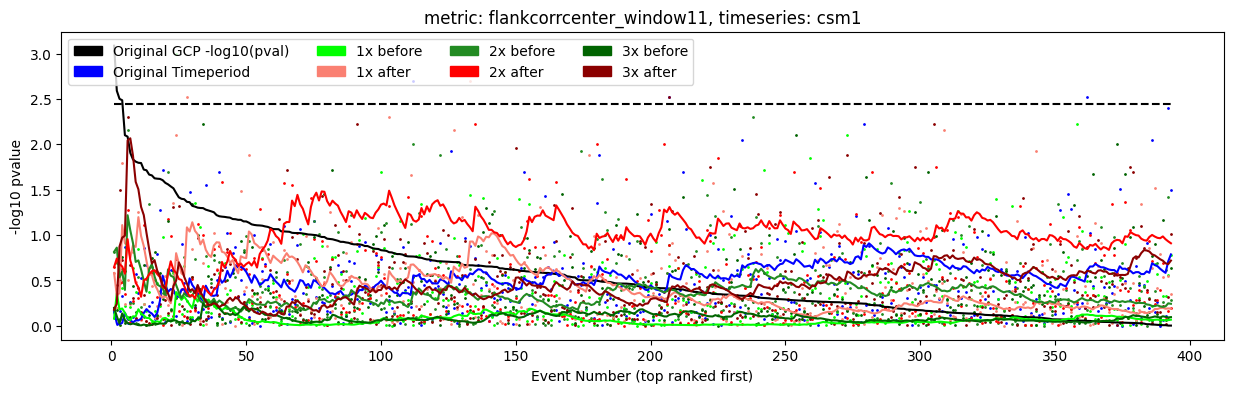

flankcorrcenter_window61
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.5408918216356727
Rankbias p-value: Original Timeperiod pval: 0.08997782108730551
meta-analysis p-value: 1x before pval: 0.3817236552689462
Rankbias p-value: 1x before pval: 0.12086968696336092
meta-analysis p-value: 1x after pval: 0.6442711457708459
Rankbias p-value: 1x after pval: 0.8036902048722059
meta-analysis p-value: 2x before pval: 0.9872025594881024
Rankbias p-value: 2x before pval: 0.87275903938095
meta-analysis p-value: 2x after pval: 0.2955408918216357
Rankbias p-value: 2x after pval: 0.2313171644055323
meta-analysis p-value: 3x before pval: 0.9738052389522096
Rankbias p-value: 3x before pval: 0.6318755882609073
meta-analysis p-value: 3x after pval: 0.47210557888422316
Rankbias p-value: 3x after pval: 0.8359582535545567


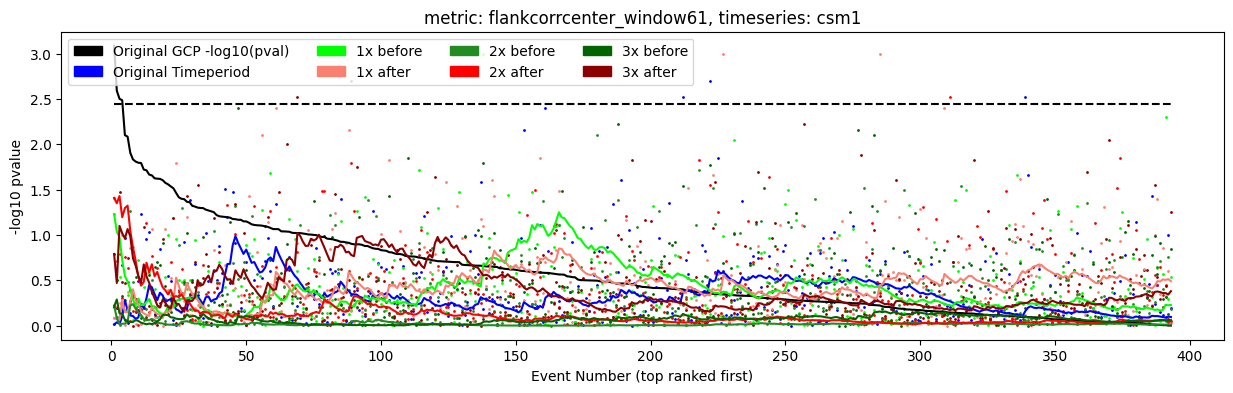

flankcorrcenter_window301
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.6838632273545291
Rankbias p-value: Original Timeperiod pval: 0.14077738406601775
meta-analysis p-value: 1x before pval: 0.7980403919216157
Rankbias p-value: 1x before pval: 0.5977720096250685
meta-analysis p-value: 1x after pval: 0.9796040791841631
Rankbias p-value: 1x after pval: 0.5340995330898077
meta-analysis p-value: 2x before pval: 0.7476504699060188
Rankbias p-value: 2x before pval: 0.918130560467781
meta-analysis p-value: 2x after pval: 0.8152369526094781
Rankbias p-value: 2x after pval: 0.2456337888905762
meta-analysis p-value: 3x before pval: 0.5496900619876025
Rankbias p-value: 3x before pval: 0.556950508495319
meta-analysis p-value: 3x after pval: 0.6972605478904219
Rankbias p-value: 3x after pval: 0.7780534153042113


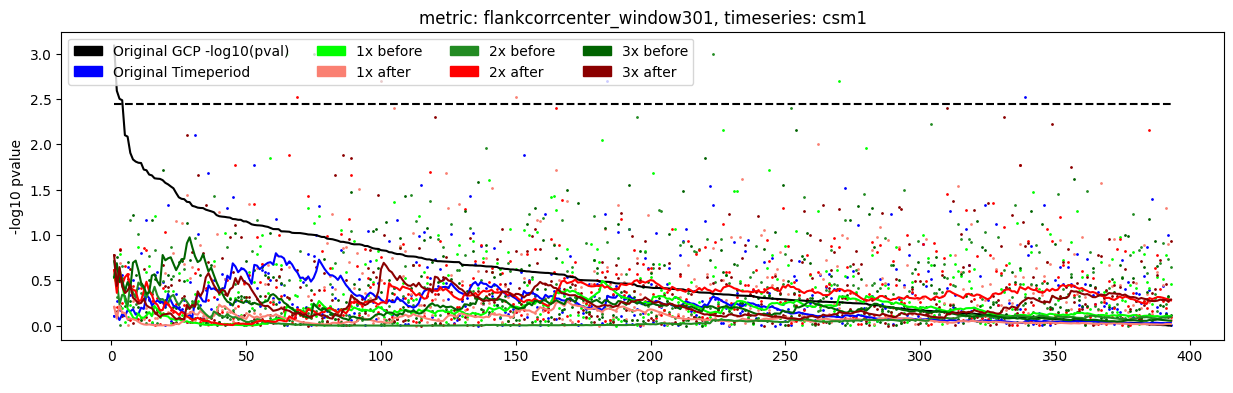

flankcorrcenter_window901
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8308338332333534
Rankbias p-value: Original Timeperiod pval: 0.6116945990433948
meta-analysis p-value: 1x before pval: 0.6306738652269547
Rankbias p-value: 1x before pval: 0.2626466317950832
meta-analysis p-value: 1x after pval: 0.880623875224955
Rankbias p-value: 1x after pval: 0.44576141073555653
meta-analysis p-value: 2x before pval: 0.1893621275744851
Rankbias p-value: 2x before pval: 0.4628091741900936
meta-analysis p-value: 2x after pval: 0.523495300939812
Rankbias p-value: 2x after pval: 0.1935348215932826
meta-analysis p-value: 3x before pval: 0.408118376324735
Rankbias p-value: 3x before pval: 0.5573118755611521
meta-analysis p-value: 3x after pval: 0.15396920615876825
Rankbias p-value: 3x after pval: 0.224131499145017


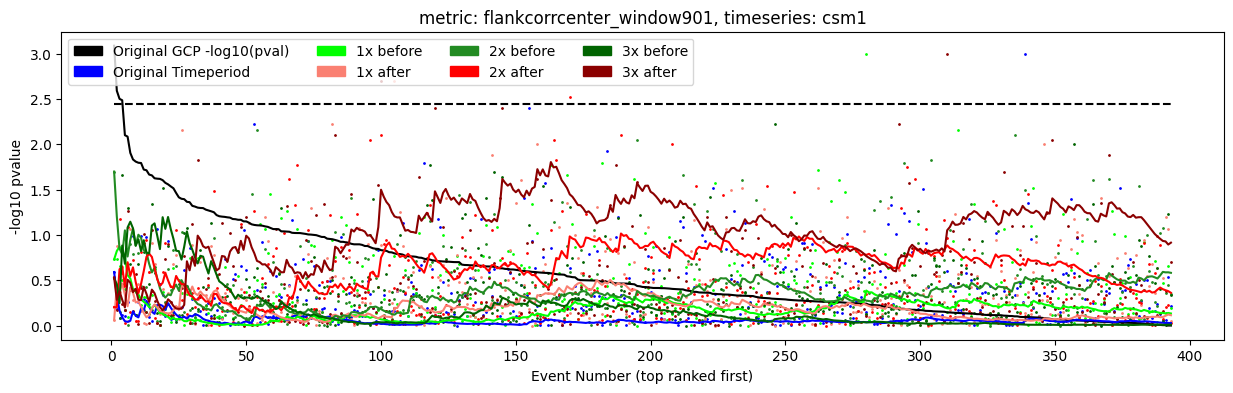

compositez
flankcorrcenter_window11
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8652269546090782
Rankbias p-value: Original Timeperiod pval: 0.040613022652464255
meta-analysis p-value: 1x before pval: 0.02299540091981604
Rankbias p-value: 1x before pval: 0.675408156369835
meta-analysis p-value: 1x after pval: 0.9260147970405919
Rankbias p-value: 1x after pval: 0.6498359689191744
meta-analysis p-value: 2x before pval: 0.8250349930013997
Rankbias p-value: 2x before pval: 0.08396646394613805
meta-analysis p-value: 2x after pval: 0.6260747850429914
Rankbias p-value: 2x after pval: 0.03884826736590237
meta-analysis p-value: 3x before pval: 0.6176764647070586
Rankbias p-value: 3x before pval: 0.8034364801821097
meta-analysis p-value: 3x after pval: 0.6150769846030794
Rankbias p-value: 3x after pval: 0.3688147866407403


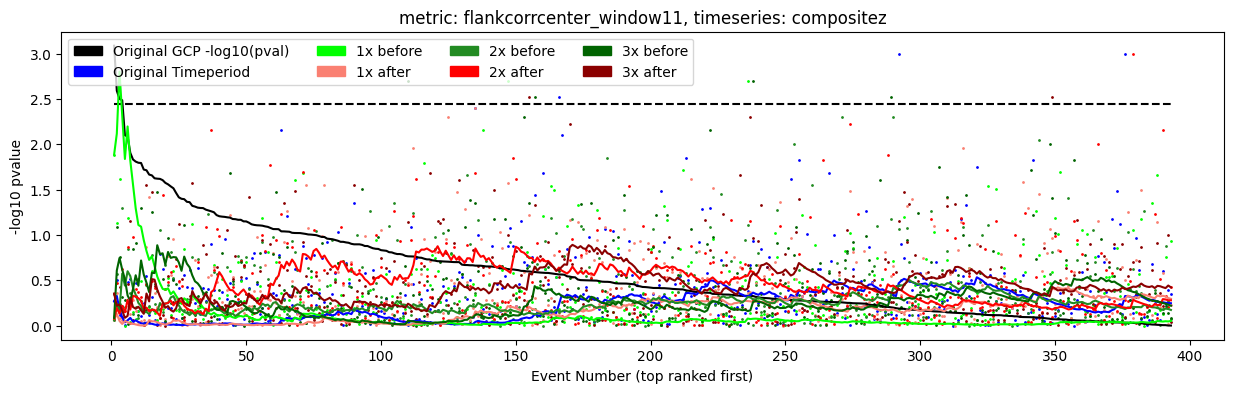

flankcorrcenter_window61
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8448310337932413
Rankbias p-value: Original Timeperiod pval: 0.5136903051869287
meta-analysis p-value: 1x before pval: 0.28954209158168365
Rankbias p-value: 1x before pval: 0.4499246424627173
meta-analysis p-value: 1x after pval: 0.8006398720255948
Rankbias p-value: 1x after pval: 0.7261938563343171
meta-analysis p-value: 2x before pval: 0.9836032793441312
Rankbias p-value: 2x before pval: 0.29807319028358825
meta-analysis p-value: 2x after pval: 0.09798040391921616
Rankbias p-value: 2x after pval: 0.41039333151286017
meta-analysis p-value: 3x before pval: 0.40471905618876225
Rankbias p-value: 3x before pval: 0.704618176355293
meta-analysis p-value: 3x after pval: 0.6050789842031594
Rankbias p-value: 3x after pval: 0.759807842098108


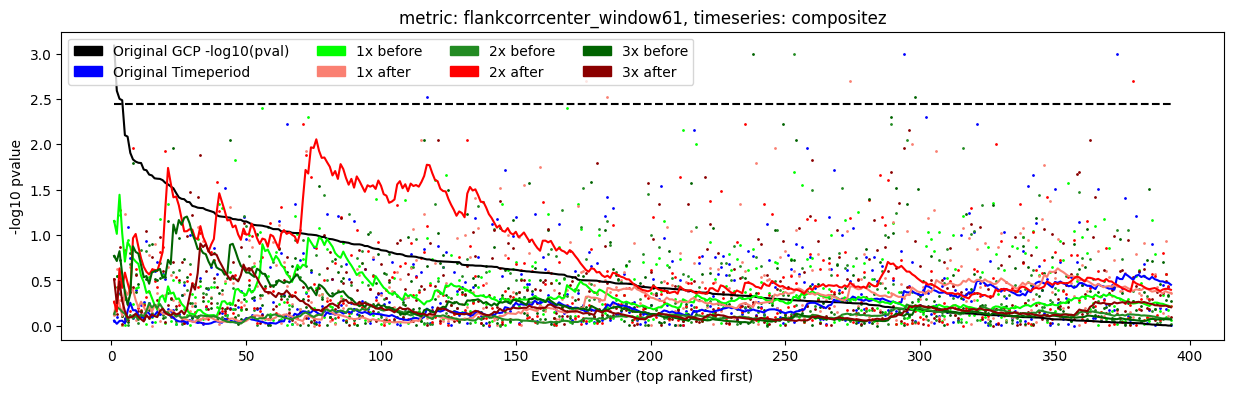

flankcorrcenter_window301
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.5246950609878024
Rankbias p-value: Original Timeperiod pval: 0.4850325359273892
meta-analysis p-value: 1x before pval: 0.15216956608678264
Rankbias p-value: 1x before pval: 0.1909079682053328
meta-analysis p-value: 1x after pval: 0.8632273545290942
Rankbias p-value: 1x after pval: 0.8872127245974042
meta-analysis p-value: 2x before pval: 0.9620075984803039
Rankbias p-value: 2x before pval: 0.9808768494377527
meta-analysis p-value: 2x after pval: 0.06538692261547689
Rankbias p-value: 2x after pval: 0.32954592163786833
meta-analysis p-value: 3x before pval: 0.5910817836432714
Rankbias p-value: 3x before pval: 0.9959887743409345
meta-analysis p-value: 3x after pval: 0.4323135372925415
Rankbias p-value: 3x after pval: 0.2467878145180592


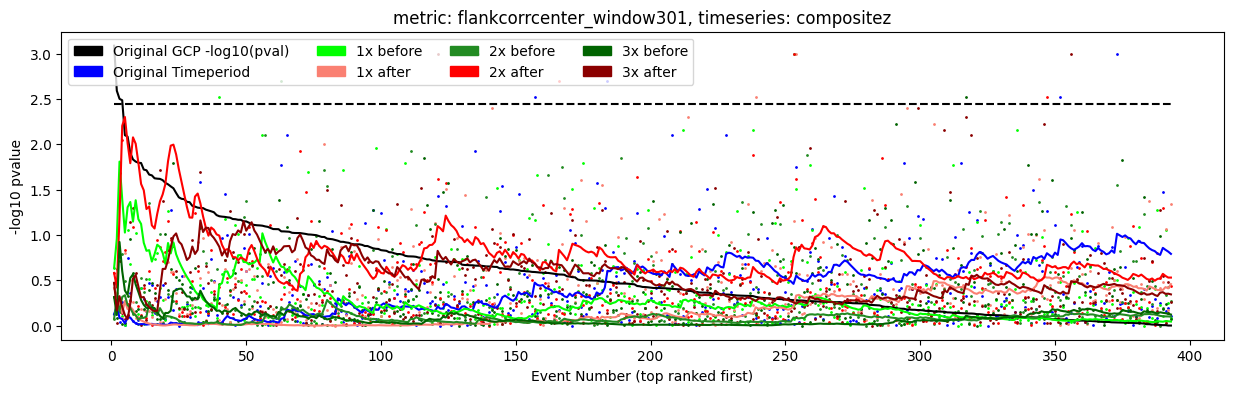

flankcorrcenter_window901
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9612077584483103
Rankbias p-value: Original Timeperiod pval: 0.2195029418172998
meta-analysis p-value: 1x before pval: 0.20595880823835233
Rankbias p-value: 1x before pval: 0.060128353385448814
meta-analysis p-value: 1x after pval: 0.5842831433713258
Rankbias p-value: 1x after pval: 0.7494417936695464
meta-analysis p-value: 2x before pval: 0.3473305338932214
Rankbias p-value: 2x before pval: 0.4886819915229031
meta-analysis p-value: 2x after pval: 0.0673865226954609
Rankbias p-value: 2x after pval: 0.3057324973337794
meta-analysis p-value: 3x before pval: 0.8232353529294141
Rankbias p-value: 3x before pval: 0.997081840086092
meta-analysis p-value: 3x after pval: 0.01219756048790242
Rankbias p-value: 3x after pval: 0.4297119745902239


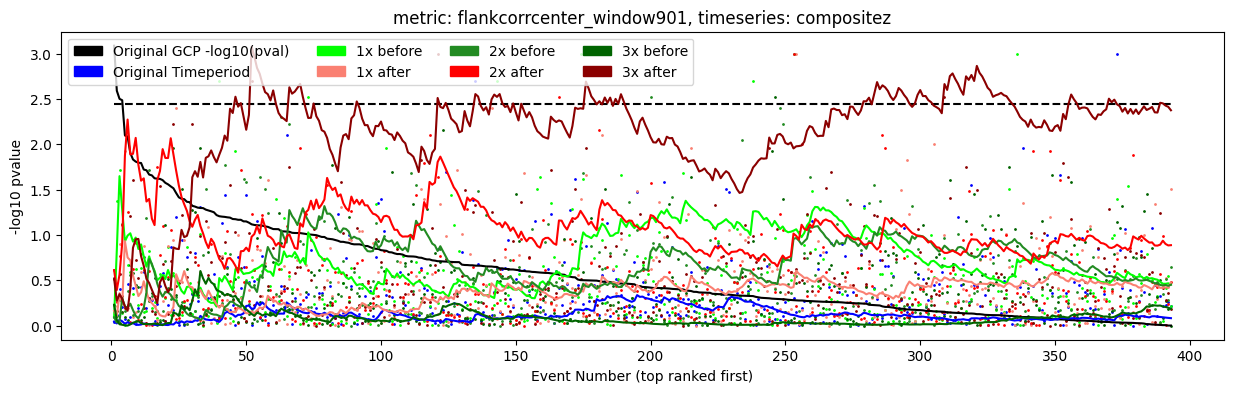

csm1
NEGATIVE flankcorrcenter_window11
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.3815236952609478
Rankbias p-value: Original Timeperiod pval: 0.6874948405071085
meta-analysis p-value: 1x before pval: 0.10577884423115377
Rankbias p-value: 1x before pval: 0.03781963245299299
meta-analysis p-value: 1x after pval: 0.7960407918416317
Rankbias p-value: 1x after pval: 0.5300959133716907
meta-analysis p-value: 2x before pval: 0.5970805838832234
Rankbias p-value: 2x before pval: 0.7524894537066971
meta-analysis p-value: 2x after pval: 0.99500099980004
Rankbias p-value: 2x after pval: 0.7576677060396977
meta-analysis p-value: 3x before pval: 0.10957808438312337
Rankbias p-value: 3x before pval: 0.6858729671854458
meta-analysis p-value: 3x after pval: 0.396120775844831
Rankbias p-value: 3x after pval: 0.17894241487693835


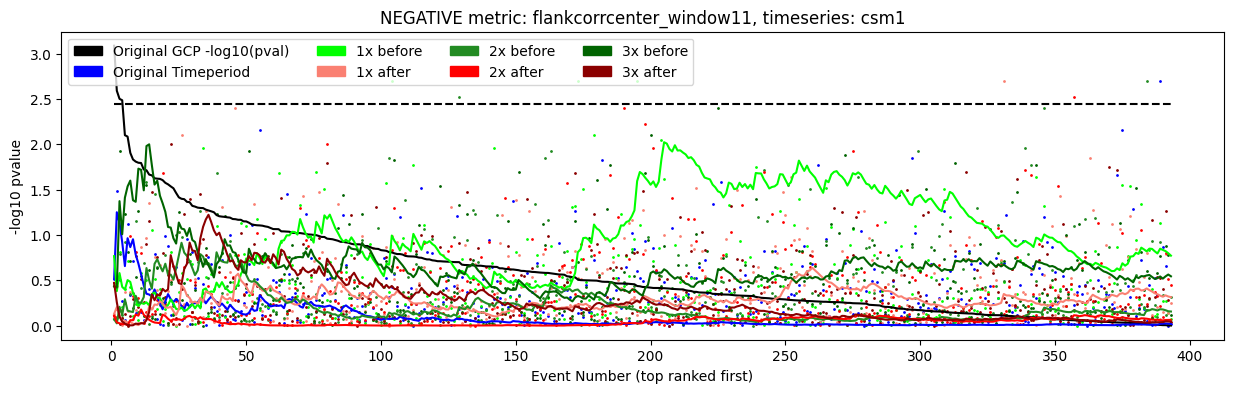

NEGATIVE flankcorrcenter_window61
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.27394521095780844
Rankbias p-value: Original Timeperiod pval: 0.9101706941243128
meta-analysis p-value: 1x before pval: 0.9718056388722256
Rankbias p-value: 1x before pval: 0.8793142422067994
meta-analysis p-value: 1x after pval: 0.34233153369326136
Rankbias p-value: 1x after pval: 0.19656327425498077
meta-analysis p-value: 2x before pval: 0.39172165566886624
Rankbias p-value: 2x before pval: 0.12743182326798846
meta-analysis p-value: 2x after pval: 0.6820635872825436
Rankbias p-value: 2x after pval: 0.7689615544281744
meta-analysis p-value: 3x before pval: 0.32933413317336535
Rankbias p-value: 3x before pval: 0.36846947431954735
meta-analysis p-value: 3x after pval: 0.6820635872825436
Rankbias p-value: 3x after pval: 0.16426819549553306


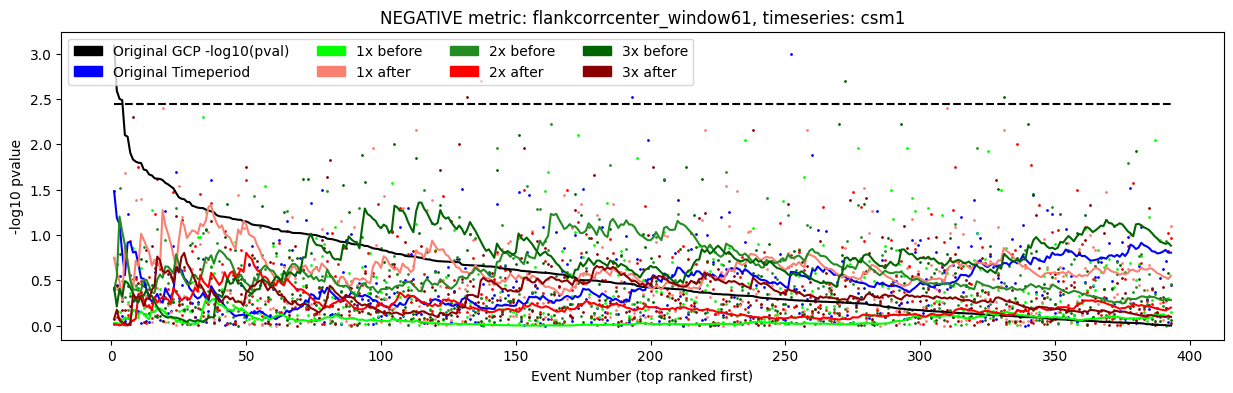

NEGATIVE flankcorrcenter_window301
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.06598680263947211
Rankbias p-value: Original Timeperiod pval: 0.859427003810999
meta-analysis p-value: 1x before pval: 0.6868626274745051
Rankbias p-value: 1x before pval: 0.4025821544652109
meta-analysis p-value: 1x after pval: 0.5720855828834233
Rankbias p-value: 1x after pval: 0.46626429253404583
meta-analysis p-value: 2x before pval: 0.057588482303539294
Rankbias p-value: 2x before pval: 0.08200799326022751
meta-analysis p-value: 2x after pval: 0.45030993801239755
Rankbias p-value: 2x after pval: 0.7546542533569723
meta-analysis p-value: 3x before pval: 0.45670865826834633
Rankbias p-value: 3x before pval: 0.4434109340861152
meta-analysis p-value: 3x after pval: 0.5042991401719656
Rankbias p-value: 3x after pval: 0.2222190599728367


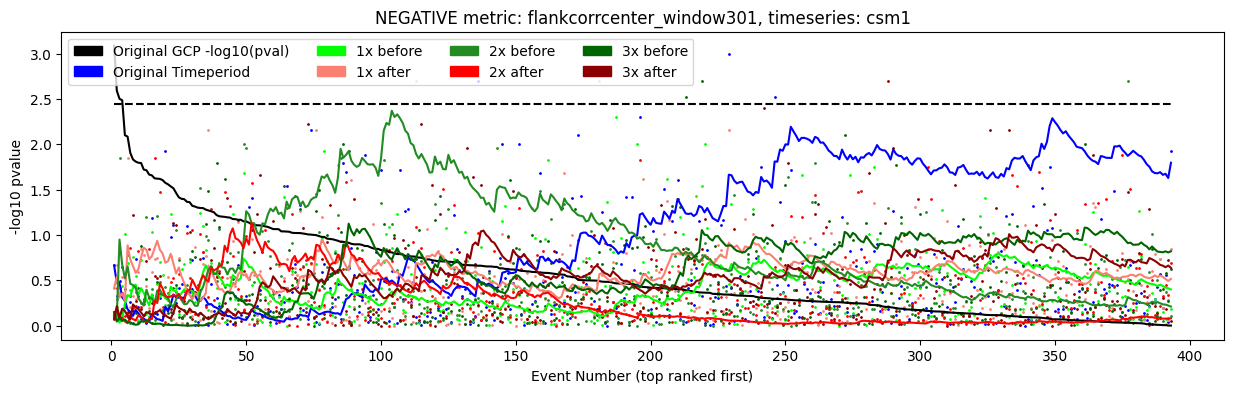

NEGATIVE flankcorrcenter_window901
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.46270745850829836
Rankbias p-value: Original Timeperiod pval: 0.38865618591256085
meta-analysis p-value: 1x before pval: 0.9178164367126574
Rankbias p-value: 1x before pval: 0.737651716371506
meta-analysis p-value: 1x after pval: 0.27394521095780844
Rankbias p-value: 1x after pval: 0.5546003328388598
meta-analysis p-value: 2x before pval: 0.7418516296740651
Rankbias p-value: 2x before pval: 0.537554368077017
meta-analysis p-value: 2x after pval: 0.9262147570485902
Rankbias p-value: 2x after pval: 0.8067162747017713
meta-analysis p-value: 3x before pval: 0.6610677864427115
Rankbias p-value: 3x before pval: 0.44304951946068394
meta-analysis p-value: 3x after pval: 0.7406518696260748
Rankbias p-value: 3x after pval: 0.776142309713678


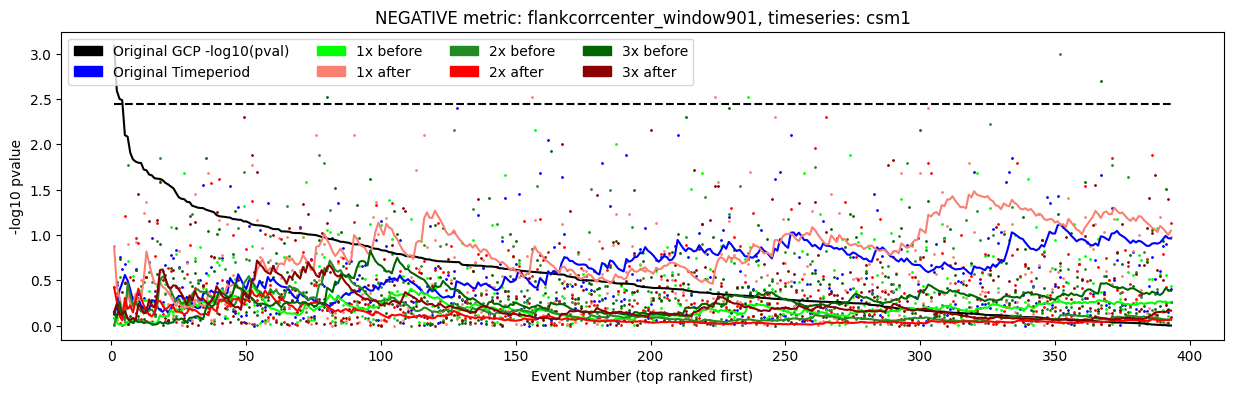

compositez
NEGATIVE flankcorrcenter_window11
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.4615076984603079
Rankbias p-value: Original Timeperiod pval: 0.9594667674379488
meta-analysis p-value: 1x before pval: 0.4539092181563687
Rankbias p-value: 1x before pval: 0.3249211667211027
meta-analysis p-value: 1x after pval: 0.1773645270945811
Rankbias p-value: 1x after pval: 0.3505031695091577
meta-analysis p-value: 2x before pval: 0.6312737452509498
Rankbias p-value: 2x before pval: 0.9161745721127033
meta-analysis p-value: 2x after pval: 0.6934613077384523
Rankbias p-value: 2x after pval: 0.9612286913692717
meta-analysis p-value: 3x before pval: 0.13617276544691062
Rankbias p-value: 3x before pval: 0.19681719707485223
meta-analysis p-value: 3x after pval: 0.5650869826034792
Rankbias p-value: 3x after pval: 0.6315303816983974


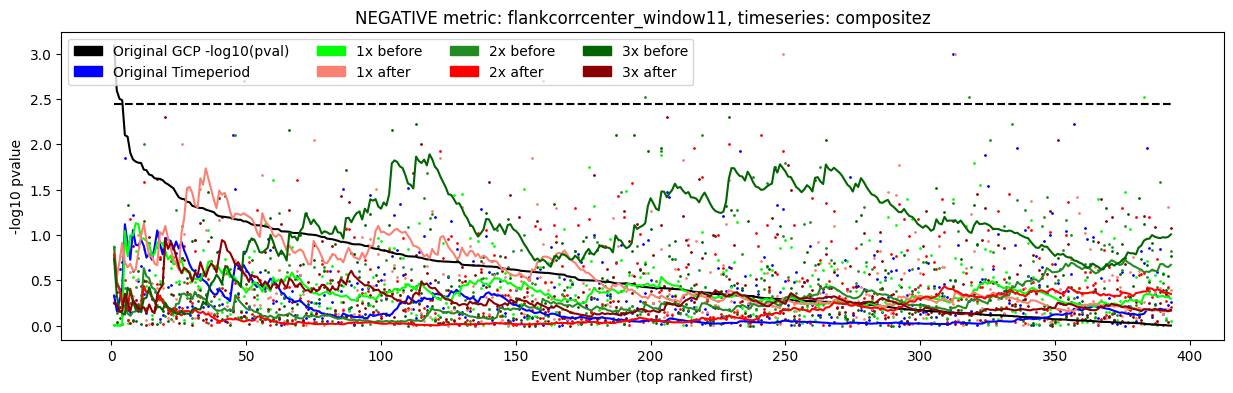

NEGATIVE flankcorrcenter_window61
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.5808838232353529
Rankbias p-value: Original Timeperiod pval: 0.4866746319588887
meta-analysis p-value: 1x before pval: 0.17476504699060189
Rankbias p-value: 1x before pval: 0.5504376023675078
meta-analysis p-value: 1x after pval: 0.529494101179764
Rankbias p-value: 1x after pval: 0.2741109770717075
meta-analysis p-value: 2x before pval: 0.6766646670665867
Rankbias p-value: 2x before pval: 0.7022440410279878
meta-analysis p-value: 2x after pval: 0.9468106378724255
Rankbias p-value: 2x after pval: 0.589962527862038
meta-analysis p-value: 3x before pval: 0.5060987802439512
Rankbias p-value: 3x before pval: 0.2956978943398896
meta-analysis p-value: 3x after pval: 0.5980803839232154
Rankbias p-value: 3x after pval: 0.24047691148943823


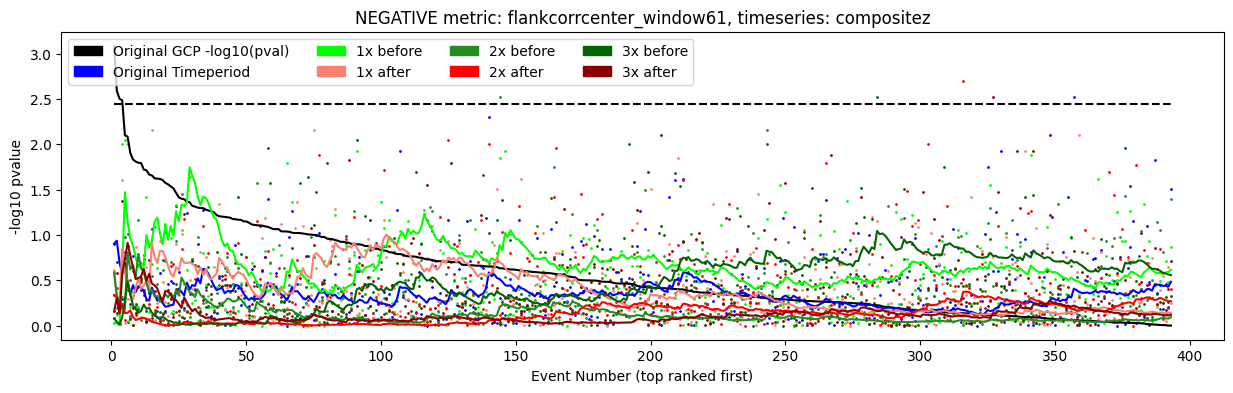

NEGATIVE flankcorrcenter_window301
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.22495500899820037
Rankbias p-value: Original Timeperiod pval: 0.5153323465212636
meta-analysis p-value: 1x before pval: 0.46630673865226957
Rankbias p-value: 1x before pval: 0.8093410369670073
meta-analysis p-value: 1x after pval: 0.5440911817636472
Rankbias p-value: 1x after pval: 0.11296258902322243
meta-analysis p-value: 2x before pval: 0.3817236552689462
Rankbias p-value: 2x before pval: 0.019165851802040296
meta-analysis p-value: 2x after pval: 0.9978004399120176
Rankbias p-value: 2x after pval: 0.670785297624856
meta-analysis p-value: 3x before pval: 0.3333333333333333
Rankbias p-value: 3x before pval: 0.00402210953836377
meta-analysis p-value: 3x after pval: 0.7070585882823436
Rankbias p-value: 3x after pval: 0.7535009530122913


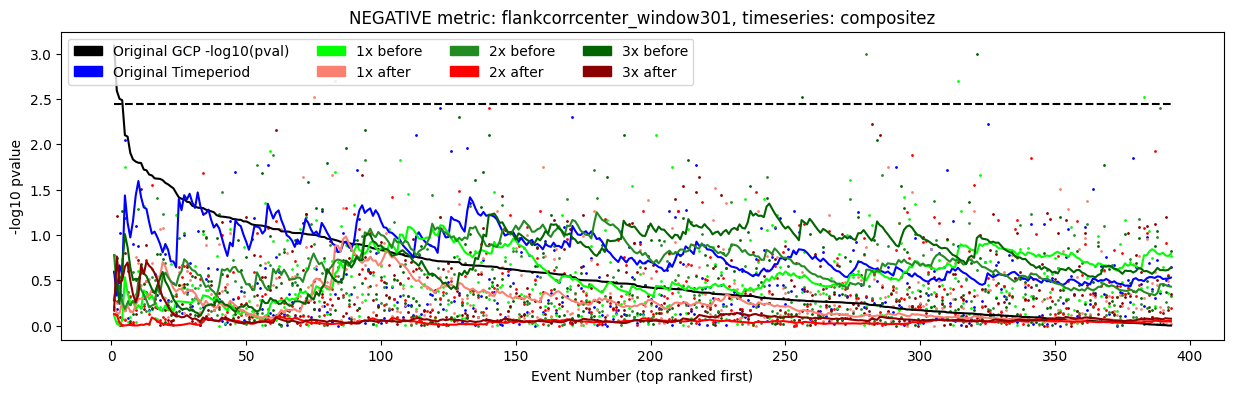

NEGATIVE flankcorrcenter_window901
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.4195160967806439
Rankbias p-value: Original Timeperiod pval: 0.780767620481482
meta-analysis p-value: 1x before pval: 0.7670465906818636
Rankbias p-value: 1x before pval: 0.9399807830861013
meta-analysis p-value: 1x after pval: 0.5088982203559288
Rankbias p-value: 1x after pval: 0.2508494961273269
meta-analysis p-value: 2x before pval: 0.5664867026594681
Rankbias p-value: 2x before pval: 0.5116830027679403
meta-analysis p-value: 2x after pval: 0.9148170365926814
Rankbias p-value: 2x after pval: 0.6945883743193004
meta-analysis p-value: 3x before pval: 0.20915816836632672
Rankbias p-value: 3x before pval: 0.002926338177794868
meta-analysis p-value: 3x after pval: 0.9530093981203759
Rankbias p-value: 3x after pval: 0.5706474597126123


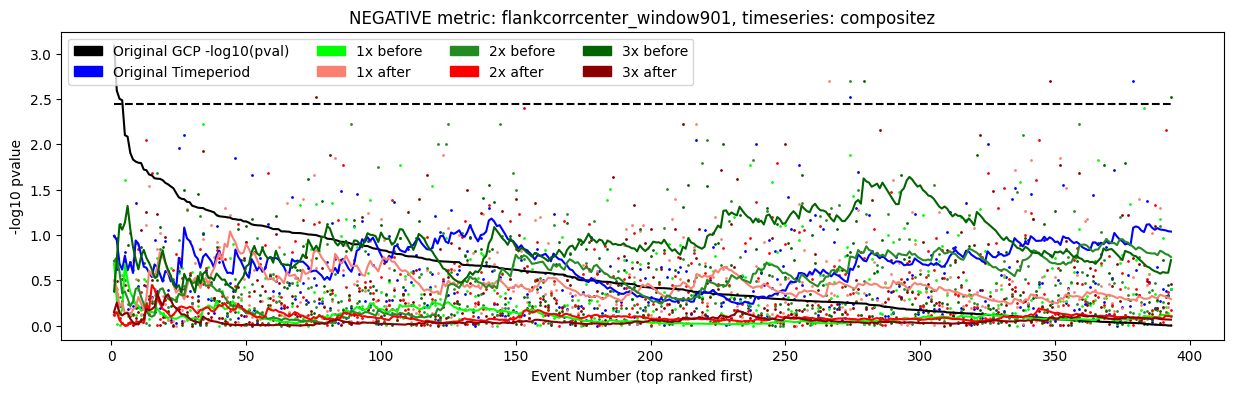

In [13]:
spannames = ['test', 'control1', 'control2', 'control3', 'control4', 'control5', 'control6']
loa_names = ['Original Timeperiod', '1x before', '1x after', '2x before', '2x after', '3x before', '3x after']
loa_colors = ['blue', 'lime', 'salmon', 'forestgreen', 'red', 'darkgreen', 'darkred']

all_metatrendplot_pvals = []

windows = ['11','61','301','901']
for signalname, pvals in [('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  for metricname in (['flankcorrcenter_window'+x for x in windows]):
    print(metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[np.array([x["pval_"+metricname] for x in pvals[y]])
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+metricname,
                                       pval) )

for signalname, pvals in [('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  for metricname in (['flankcorrcenter_window'+x for x in windows]):
    print("NEGATIVE", metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "NEGATIVE metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[(1-np.array([x["pval_"+metricname] for x in pvals[y]]))
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+"negative-"+metricname,
                                       pval) )


In [14]:
[(x[0], x[1], (x[1]*len(all_metatrendplot_pvals) )/(i+1) )
  for (i,x) in enumerate(sorted(all_metatrendplot_pvals, key=lambda x: x[1]))]


[('span:3x after; signal:compositez; metric:flankcorrcenter_window901',
  0.01219756048790242,
  1.366126774645071),
 ('span:1x before; signal:compositez; metric:flankcorrcenter_window11',
  0.02299540091981604,
  1.2877424515096982),
 ('span:2x before; signal:csm1; metric:negative-flankcorrcenter_window301',
  0.057588482303539294,
  2.1499700059988003),
 ('span:2x after; signal:compositez; metric:flankcorrcenter_window301',
  0.06538692261547689,
  1.830833833233353),
 ('span:Original Timeperiod; signal:csm1; metric:negative-flankcorrcenter_window301',
  0.06598680263947211,
  1.4781043791241752),
 ('span:2x after; signal:compositez; metric:flankcorrcenter_window901',
  0.0673865226954609,
  1.2578817569819367),
 ('span:3x after; signal:csm1; metric:flankcorrcenter_window11',
  0.09518096380723855,
  1.5228954209158168),
 ('span:2x after; signal:compositez; metric:flankcorrcenter_window61',
  0.09798040391921616,
  1.3717256548690262),
 ('span:1x before; signal:csm1; metric:negative-